In [2]:
import os



os.environ["KERAS_BACKEND"] = "tensorflow"



import re

import numpy as np

import matplotlib.pyplot as plt



import tensorflow as tf

import keras

from keras import layers

from keras.applications import efficientnet

from keras.layers import TextVectorization



keras.utils.set_random_seed(111)

In [3]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!unzip -qq Flickr8k_Dataset.zip

!unzip -qq Flickr8k_text.zip

!rm Flickr8k_Dataset.zip Flickr8k_text.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
image_path = "Flicker8k_Dataset"



image_size = (299,299)



vocab_size = 10000



seq_length = 25



embedding_size = 512



ff_dim = 512



Batch_size = 64



epochs = 30



AUTOTUNE = tf.data.AUTOTUNE

In [5]:
def load_captions(filename):



  with open(filename) as caption_file:

    caption_data = caption_file.readlines()

    caption_mapping = {}

    text_data = []

    image_to_skip = set()



    for line in caption_data:

      line = line.rstrip('\n')



      img_name, caption = line.split("\t")

      img_name = img_name.split("#")[0]

      img_name = os.path.join(image_path, img_name.strip())



      tokens = caption.strip().split()



      if len(tokens) < 5 or len(tokens) > seq_length:

        image_to_skip.add(img_name)

        continue



      if img_name.endswith("jpg") and img_name not in image_to_skip:



        caption = "<start> " + caption.strip() + " <end>"

        text_data.append(caption)



        if img_name in caption_mapping:

          caption_mapping[img_name].append(caption)

        else:

          caption_mapping[img_name] = [caption]



      for img_name in image_to_skip:

        if img_name in caption_mapping:

          del caption_mapping[img_name]



    return caption_mapping, text_data


In [6]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):

    """Split the captioning dataset into train and validation sets.



    Args:

        caption_data (dict): Dictionary containing the mapped caption data

        train_size (float): Fraction of all the full dataset to use as training data

        shuffle (bool): Whether to shuffle the dataset before splitting



    Returns:

        Traning and validation datasets as two separated dicts

    """



    # 1. Get the list of all image names

    all_images = list(caption_data.keys())



    # 2. Shuffle if necessary

    if shuffle:

        np.random.shuffle(all_images)



    # 3. Split into training and validation sets

    train_size = int(len(caption_data) * train_size)



    training_data = {

        img_name: caption_data[img_name] for img_name in all_images[:train_size]

    }

    validation_data = {

        img_name: caption_data[img_name] for img_name in all_images[train_size:]

    }



    # 4. Return the splits

    return training_data, validation_data

In [7]:
captions_mapping, text_data = load_captions("Flickr8k.token.txt")

In [8]:
train_data, valid_data = train_val_split(captions_mapping)

print("Number of training samples: ", len(train_data))

print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


In [9]:
def custom_standardization(input_string):

  lowercase = tf.strings.lower(input_string)

  return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")



strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"

strip_chars = strip_chars.replace("<", "")

strip_chars = strip_chars.replace(">", "")



vectorization = TextVectorization(

    max_tokens = vocab_size,

    output_mode = "int",

    output_sequence_length = seq_length,

    standardize = custom_standardization,

)



vectorization.adapt(text_data)

In [10]:
image_augmentation = keras.Sequential(

    [

        layers.RandomFlip("horizontal"),

        layers.RandomRotation(0.2),

        layers.RandomContrast(0.3)

    ]

)

In [11]:
def decode_and_resize(img_path):

  img = tf.io.read_file(img_path)

  img = tf.image.decode_jpeg(img, channels=3)

  img = tf.image.resize(img, image_size)

  img = tf.image.convert_image_dtype(img, tf.float32)

  return img



def process_input(img_path, captions):

  return decode_and_resize(img_path), vectorization(captions)



def make_dataset(image, captions):



  dataset = tf.data.Dataset.from_tensor_slices((image, captions))

  dataset = dataset.shuffle(Batch_size * 8)

  dataset = dataset.map(process_input, num_parallel_calls = AUTOTUNE)

  dataset = dataset.batch(Batch_size).prefetch(AUTOTUNE)



  return dataset

In [12]:
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

In [13]:
def get_cnn_model():

  base_model = efficientnet.EfficientNetB0(

      input_shape = (*image_size, 3),

      include_top = False,

      weights = "imagenet",

  )



  base_model.trainable = False

  base_model_out = base_model.output

  base_model.out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)

  cnn_model = keras.models.Model(base_model.input, base_model.out)



  return cnn_model



In [14]:
class TransformerEncoderBlock(layers.Layer):

  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):

    super().__init__(**kwargs)

    self.embed_dim = embed_dim

    self.dense_dim = dense_dim

    self.num_heads = num_heads

    self.attention_1 = layers.MultiHeadAttention(

        num_heads = num_heads, key_dim = embed_dim, dropout = 0.0

    )

    self.layernorm_1 = layers.LayerNormalization()

    self.layernorm_2 = layers.LayerNormalization()

    self.dense_1 = layers.Dense(embed_dim, activation="relu")



  def call(self, inputs, training, mask=None):

    inputs = self.layernorm_1(inputs)

    inputs = self.dense_1(inputs)



    attention_output_1 = self.attention_1(

        query = inputs,

        value = inputs,

        key = inputs,

        attention_mask = None,

        training = training

    )



    out_1 = self.layernorm_2(inputs + attention_output_1)

    return out_1

In [15]:
class PositionalEmbedding(layers.Layer):



  def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):



    super().__init__(**kwargs)



    self.token_embeddings = layers.Embedding(

        input_dim = vocab_size, output_dim = embed_dim

    )



    self.positional_embeddings = layers.Embedding(

        input_dim = sequence_length, output_dim = embed_dim

    )



    self.sequence_length = sequence_length

    self.vocab_size = vocab_size

    self.embed_dim = embed_dim

    self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))



  def call(self, inputs):



      length = tf.shape(inputs)[-1]

      positions = tf.range(start = 0, limit = length, delta = 1)

      embedded_tokens = self.token_embeddings(inputs)

      embedded_toens = embedded_tokens * self.embed_scale

      embedded_positions = self.positional_embeddings(positions)



      return embedded_tokens + embedded_positions



  def compute_mask(self, inputs, mask = None):



      return tf.math.not_equal(inputs, 0)


In [16]:
class TransformerDecoderBlock(layers.Layer):



  def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):



    super().__init__(**kwargs)

    self.embed_dim = embed_dim

    self.ff_dim = ff_dim

    self.num_heads = num_heads



    self.attention_1 = layers.MultiHeadAttention(

        num_heads = num_heads, key_dim = embed_dim, dropout = 0.1

    )



    self.attention_2 = layers.MultiHeadAttention(

        num_heads = num_heads, key_dim = embed_dim, dropout = 0.1

    )



    self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")

    self.ffn_layer_2 = layers.Dense(embed_dim)



    self.layernorm_1 = layers.LayerNormalization()

    self.layernorm_2 = layers.LayerNormalization()

    self.layernorm_3 = layers.LayerNormalization()



    self.embedding = PositionalEmbedding(

        embed_dim = embed_dim,

        sequence_length=seq_length,

        vocab_size = vocab_size,

    )



    self.out = layers.Dense(vocab_size, activation = "softmax")



    self.dropout_1 = layers.Dropout(0.3)

    self.dropout_2 = layers.Dropout(0.5)

    self.supports_masking = True



  def call(self, inputs, encoder_outputs, training, mask=None):



    inputs = self.embedding(inputs)

    causal_mask = self.get_causal_attention_mask(inputs)



    if mask is not None:

      padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)

      combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)

      combined_mask = tf.minimum(combined_mask, causal_mask)



      attention_output_1 = self.attention_1(

          query=inputs,

          value=inputs,

          key=inputs,

          attention_mask=combined_mask,

          training=training,

        )

      out_1 = self.layernorm_1(inputs + attention_output_1)



      attention_output_2 = self.attention_2(

          query=out_1,

          value=encoder_outputs,

          key=encoder_outputs,

          attention_mask=padding_mask,

           training=training,

        )



      out_2 = self.layernorm_2(out_1 + attention_output_2)



      ffn_out = self.ffn_layer_1(out_2)

      ffn_out = self.dropout_1(ffn_out, training=training)

      ffn_out = self.ffn_layer_2(ffn_out)



      ffn_out = self.layernorm_3(ffn_out + out_2, training=training)

      ffn_out = self.dropout_2(ffn_out, training=training)

      preds = self.out(ffn_out)



      return preds



  def get_causal_attention_mask(self, inputs):

      input_shape = tf.shape(inputs)

      batch_size, sequence_length = input_shape[0], input_shape[1]

      i = tf.range(sequence_length)[:, tf.newaxis]

      j = tf.range(sequence_length)

      mask = tf.cast(i >= j, dtype="int32")

      mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))

      mult = tf.concat(

          [

              tf.expand_dims(batch_size, -1),

              tf.constant([1, 1], dtype=tf.int32),

          ],

          axis=0,

        )



      return tf.tile(mask, mult)



class ImageCaptioningModel(keras.Model):

    def __init__(

        self,

        cnn_model,

        encoder,

        decoder,

        num_captions_per_image=5,

        image_aug=None,

    ):

        super().__init__()

        self.cnn_model = cnn_model

        self.encoder = encoder

        self.decoder = decoder

        self.loss_tracker = keras.metrics.Mean(name="loss")

        self.acc_tracker = keras.metrics.Mean(name="accuracy")

        self.num_captions_per_image = num_captions_per_image

        self.image_aug = image_aug



    def calculate_loss(self, y_true, y_pred, mask):

        loss = self.loss(y_true, y_pred)

        mask = tf.cast(mask, dtype=loss.dtype)

        loss *= mask

        return tf.reduce_sum(loss) / tf.reduce_sum(mask)



    def calculate_accuracy(self, y_true, y_pred, mask):

        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))

        accuracy = tf.math.logical_and(mask, accuracy)

        accuracy = tf.cast(accuracy, dtype=tf.float32)

        mask = tf.cast(mask, dtype=tf.float32)

        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)



    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):

        encoder_out = self.encoder(img_embed, training=training)

        batch_seq_inp = batch_seq[:, :-1]

        batch_seq_true = batch_seq[:, 1:]

        mask = tf.math.not_equal(batch_seq_true, 0)

        batch_seq_pred = self.decoder(

            batch_seq_inp, encoder_out, training=training, mask=mask

        )

        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)

        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)

        return loss, acc



    def train_step(self, batch_data):

        batch_img, batch_seq = batch_data

        batch_loss = 0

        batch_acc = 0



        if self.image_aug:

            batch_img = self.image_aug(batch_img)



        # 1. Get image embeddings

        img_embed = self.cnn_model(batch_img)



        # 2. Pass each of the five captions one by one to the decoder

        # along with the encoder outputs and compute the loss as well as accuracy

        # for each caption.

        for i in range(self.num_captions_per_image):

            with tf.GradientTape() as tape:

                loss, acc = self._compute_caption_loss_and_acc(

                    img_embed, batch_seq[:, i, :], training=True

                )



                # 3. Update loss and accuracy

                batch_loss += loss

                batch_acc += acc



            # 4. Get the list of all the trainable weights

            train_vars = (

                self.encoder.trainable_variables + self.decoder.trainable_variables

            )



            # 5. Get the gradients

            grads = tape.gradient(loss, train_vars)



            # 6. Update the trainable weights

            self.optimizer.apply_gradients(zip(grads, train_vars))



        # 7. Update the trackers

        batch_acc /= float(self.num_captions_per_image)

        self.loss_tracker.update_state(batch_loss)

        self.acc_tracker.update_state(batch_acc)



        # 8. Return the loss and accuracy values

        return {

            "loss": self.loss_tracker.result(),

            "acc": self.acc_tracker.result(),

        }



    def test_step(self, batch_data):

        batch_img, batch_seq = batch_data

        batch_loss = 0

        batch_acc = 0



        # 1. Get image embeddings

        img_embed = self.cnn_model(batch_img)



        # 2. Pass each of the five captions one by one to the decoder

        # along with the encoder outputs and compute the loss as well as accuracy

        # for each caption.

        for i in range(self.num_captions_per_image):

            loss, acc = self._compute_caption_loss_and_acc(

                img_embed, batch_seq[:, i, :], training=False

            )



            # 3. Update batch loss and batch accuracy

            batch_loss += loss

            batch_acc += acc



        batch_acc /= float(self.num_captions_per_image)



        # 4. Update the trackers

        self.loss_tracker.update_state(batch_loss)

        self.acc_tracker.update_state(batch_acc)



        # 5. Return the loss and accuracy values

        return {

            "loss": self.loss_tracker.result(),

            "acc": self.acc_tracker.result(),

        }



    @property

    def metrics(self):

        # We need to list our metrics here so the `reset_states()` can be

        # called automatically.

        return [self.loss_tracker, self.acc_tracker]





cnn_model = get_cnn_model()

encoder = TransformerEncoderBlock(embed_dim=embedding_size, dense_dim=ff_dim, num_heads=1)

decoder = TransformerDecoderBlock(embed_dim=embedding_size, ff_dim=ff_dim, num_heads=2)



caption_model = ImageCaptioningModel(

    cnn_model=cnn_model,

    encoder=encoder,

    decoder=decoder,

    image_aug=image_augmentation,

)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Define the loss function

cross_entropy = keras.losses.SparseCategoricalCrossentropy(

    from_logits=False,

    reduction=None,

)



# EarlyStopping criteria

early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)





# Learning Rate Scheduler for the optimizer

class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, post_warmup_learning_rate, warmup_steps):

        super().__init__()

        self.post_warmup_learning_rate = post_warmup_learning_rate

        self.warmup_steps = warmup_steps



    def __call__(self, step):

        global_step = tf.cast(step, tf.float32)

        warmup_steps = tf.cast(self.warmup_steps, tf.float32)

        warmup_progress = global_step / warmup_steps

        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress

        return tf.cond(

            global_step < warmup_steps,

            lambda: warmup_learning_rate,

            lambda: self.post_warmup_learning_rate,

        )





# Create a learning rate schedule

num_train_steps = len(train_dataset) * epochs

num_warmup_steps = num_train_steps // 15

lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)



# Compile the model

caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

In [19]:
caption_model.fit(

    train_dataset,

    epochs=epochs,

    validation_data=valid_dataset,

    callbacks=[early_stopping],

)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 614ms/step - acc: 0.3485 - loss: 18.0394 - val_acc: 0.3629 - val_loss: 17.2093
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 610ms/step - acc: 0.3667 - loss: 16.8708 - val_acc: 0.3746 - val_loss: 16.5253
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 613ms/step - acc: 0.3810 - loss: 15.9961 - val_acc: 0.3850 - val_loss: 16.0015
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 610ms/step - acc: 0.3927 - loss: 15.3030 - val_acc: 0.3919 - val_loss: 15.6959
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 609ms/step - acc: 0.4030 - loss: 14.7661 - val_acc: 0.3968 - val_loss: 15.4462
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 612ms/step - acc: 0.4139 - loss: 14.2505 - val_acc: 0.4014 - val_loss: 15.2739
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 613ms/step - acc: 0.4216 - loss: 13.8614 - val_acc: 0.4051 - val_loss: 15.1618
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 59s 611ms/step - acc: 0.4304 - loss: 13.4665 - val_acc: 0.4075 - val_loss: 15.1275
Epoch 9/30
96/96 ━━━━━━━━━━━━━━━

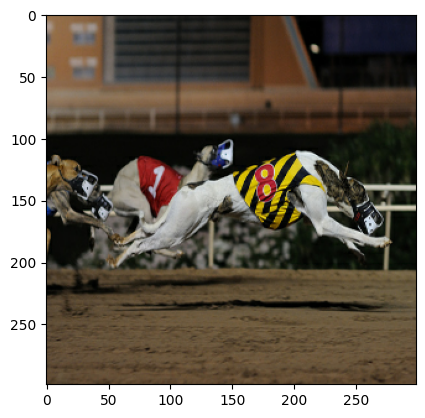

Predicted Caption:  a greyhound racing on a track


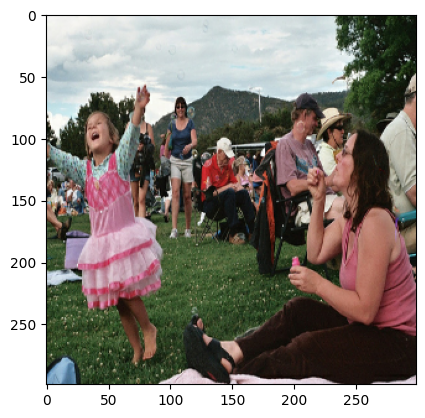

Predicted Caption:  a group of people are sitting on a bench in a field


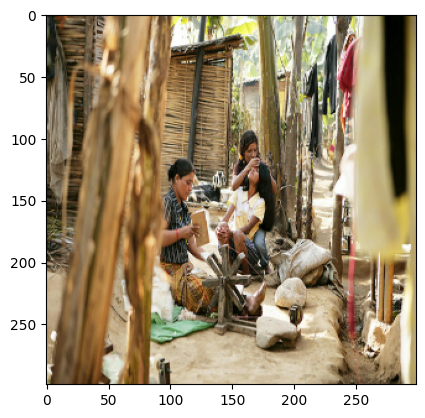

Predicted Caption:  a man and a woman sit on a bench with a brown horse


In [27]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = seq_length - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()